In [65]:
# Re-importing necessary packages after the execution state reset
import pandas as pd
import numpy as np

# Re-load the dataset
df_new = pd.read_csv('../data/transform/match_details_transformed.csv')

In [66]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    3040 non-null   int64  
 1   match_api_id                  3040 non-null   int64  
 2   season                        3040 non-null   object 
 3   stage                         3040 non-null   int64  
 4   date                          3040 non-null   object 
 5   away_team                     3040 non-null   int64  
 6   home_team                     3040 non-null   int64  
 7   home_team_goal                3040 non-null   int64  
 8   away_team_goal                3040 non-null   int64  
 9   result_match                  3040 non-null   int64  
 10  away_possession               3040 non-null   int64  
 11  home_shoton                   3040 non-null   int64  
 12  home_possession               3040 non-null   int64  
 13  awa

In [67]:
def calculate_rolling_averages(rolling_window_size, df, stat_columns):
    """
    Calculate rolling averages for various statistics without including the current match.

    Args:
    - rolling_window_size (int): Number of previous matches to include in the rolling average.
    - df (pd.DataFrame): The DataFrame containing the match data.
    - stat_columns (dict): A dictionary with keys for each stat category (e.g., 'goals', 'possession', 'shots_on'),
                           and values being another dictionary with 'home' and 'away' keys mapping to the respective columns.

    Returns:
    - pd.DataFrame: The DataFrame with new rolling average columns added.
    """

    # Iterate through each stat category
    for stat, columns in stat_columns.items():
        # Define new feature names for rolling features
        home_feature_name = f'home_{stat}_rolling'
        away_feature_name = f'away_{stat}_rolling'

        # Calculate rolling averages for home and away statistics
        for team_type in ['home', 'away']:
            # Sort by team and date
            df.sort_values(by=[f'{team_type}_team', 'date'], ascending=True, inplace=True)
            
            # Calculate rolling averages for the given stat
            df[home_feature_name if team_type == 'home' else away_feature_name] = (
                df.groupby(f'{team_type}_team')[columns[team_type]]
                .apply(lambda x: x.shift().rolling(window=rolling_window_size).mean())
                .reset_index(level=0, drop=True)
            )
            
            # Calculate the means for rolling features
            rolling_means = df.groupby(f'{team_type}_team')[home_feature_name if team_type == 'home' else away_feature_name].transform('mean')
            
            # Fill NaN values in rolling features with the team-specific means
            df[home_feature_name if team_type == 'home' else away_feature_name] = (
                df[home_feature_name if team_type == 'home' else away_feature_name].fillna(rolling_means)
            )

    return df

# Usage example with goals, possession, and shots_on
stat_columns = {
    'goals': {
        'home': 'home_team_goal',
        'away': 'away_team_goal'
    },
    'possession': {
        'home': 'home_possession',
        'away': 'away_possession'
    },
    'shots_on': {
        'home': 'home_shoton',
        'away': 'away_shoton'
    }
}
df_new = calculate_rolling_averages(4, df=df_new, stat_columns=stat_columns)


In [68]:
cr = ['match_api_id', 'season', 'stage', 'date', 'away_team', 'home_team', 'home_team_goal', 'away_team_goal', 'away_possession', 'home_shoton', 'home_possession', 'away_shoton', 'Unnamed: 0']

In [69]:
# from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # or any other model you're using
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# Define a range of window sizes to test
window_sizes = [3, 4, 5, 6, 7, 10, 12]

# Define your statistical categories and their corresponding columns
stat_columns = {
    'goals': {
        'home': 'home_team_goal',
        'away': 'away_team_goal'
    },
    'possession': {
        'home': 'home_possession',
        'away': 'away_possession'
    },
    'shots_on': {
        'home': 'home_shoton',
        'away': 'away_shoton'
    }
}

# Placeholder for best score and corresponding window size
best_score = -float('inf')
best_window_size = None

# Iterate over window sizes to find the best one
for window_size in window_sizes:
    # Calculate rolling averages using the current window size
    df_with_rolling = calculate_rolling_averages(window_size, df_new.copy(), stat_columns)

    df_with_rolling = df_with_rolling.drop(cr, axis=1)
    
    # Extract features and target for model training
    X = df_with_rolling.drop(['result_match'], axis=1)
    y = df_with_rolling['result_match']
    
    # Define your model
    model = XGBClassifier(random_state=42)  # Use your actual model here
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # Change scoring method as needed
    
    # Calculate the mean score
    mean_score = scores.mean()
    
    # Update best score and window size if current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_window_size = window_size

# best_window_size now holds the size of the window that gave the best performance
print(f"Best window size: {best_window_size} with score: {best_score}")

Best window size: 6 with score: 0.4855263157894737


In [70]:
df_with_rolling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3040 entries, 386 to 3016
Data columns (total 50 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   result_match                  3040 non-null   int64  
 1   player_rating_home_player_1   3040 non-null   int64  
 2   player_rating_home_player_2   3040 non-null   int64  
 3   player_rating_home_player_3   3040 non-null   int64  
 4   player_rating_home_player_4   3040 non-null   int64  
 5   player_rating_home_player_5   3040 non-null   int64  
 6   player_rating_home_player_6   3040 non-null   int64  
 7   player_rating_home_player_7   3040 non-null   int64  
 8   player_rating_home_player_8   3040 non-null   int64  
 9   player_rating_home_player_9   3040 non-null   int64  
 10  player_rating_home_player_10  3040 non-null   int64  
 11  player_rating_home_player_11  3040 non-null   int64  
 12  player_rating_away_player_1   3040 non-null   int64  
 13  player

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assume df_with_rolling is your DataFrame with rolling averages calculated
X = df_with_rolling.drop(['result_match'], axis=1)
y = df_with_rolling['result_match']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBClassifier
model = XGBClassifier(random_state=42, enable_categorical=True)

# Train the model
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Get feature importances
feature_importances = model.feature_importances_

# Sort the feature importances in descending order and print them
sorted_idx = feature_importances.argsort()[::-1]
for index in sorted_idx:
    print(f"{X_train.columns[index]}: {feature_importances[index]}")

Accuracy: 0.4868421052631579
away_team_strength: 0.04263915494084358
home_team_strength: 0.03928762301802635
home_goals_rolling: 0.031553737819194794
player_rating_home_player_10: 0.03119572252035141
points_diff: 0.031093880534172058
player_rating_home_player_8: 0.030883198603987694
points_away: 0.03038109466433525
away_goals_rolling: 0.029275665059685707
player_rating_home_player_7: 0.028754808008670807
avg_possession_home: 0.028362981975078583
player_rating_home_player_9: 0.027881212532520294
away_shots_on_rolling: 0.027702994644641876
player_rating_home_player_11: 0.027689743787050247
player_rating_away_player_1: 0.027593450620770454
home_shots_on_rolling: 0.027194900438189507
home_avg_goals_conceded: 0.026999138295650482
player_rating_away_player_11: 0.026940038427710533
avg_possession_away: 0.02681226097047329
win_eachother_away: 0.026802554726600647
points_home: 0.02650776132941246
win_eachother_home: 0.026208167895674706
home_avg_goals_scored: 0.026034265756607056
home_possessio

Class 0 summary plot:


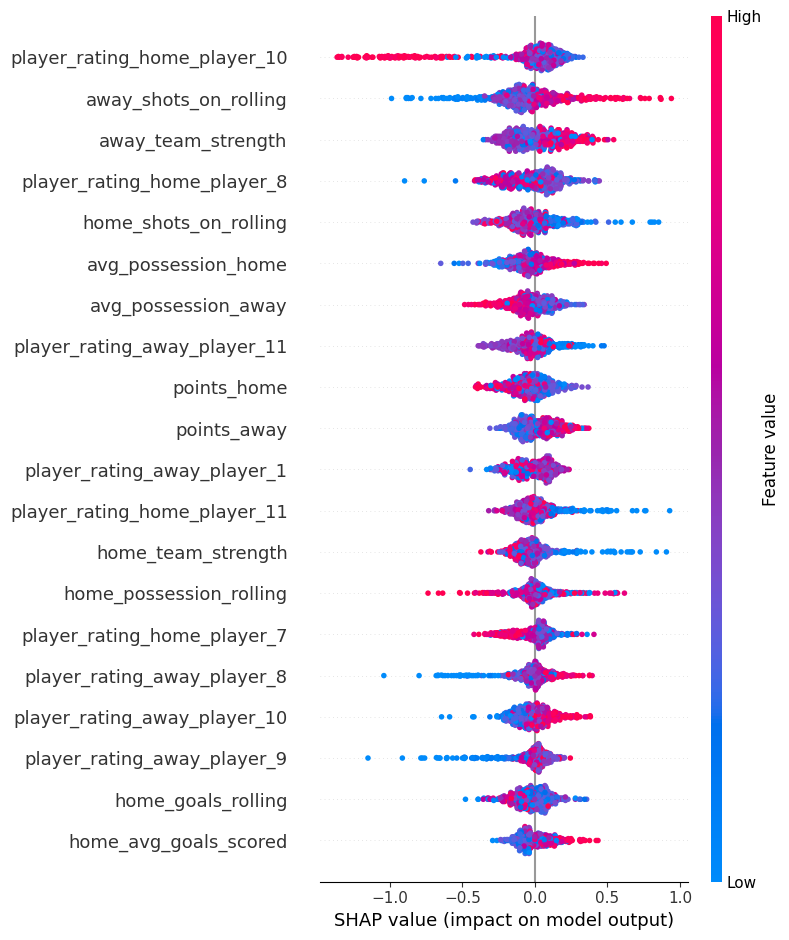

Class 1 summary plot:


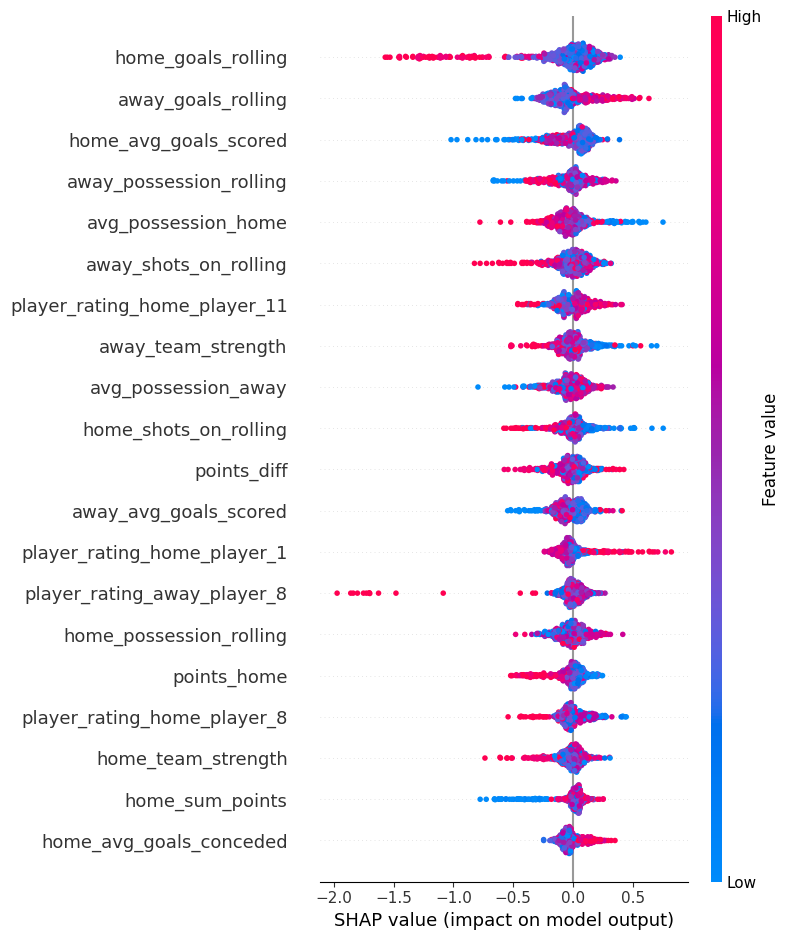

Class 2 summary plot:


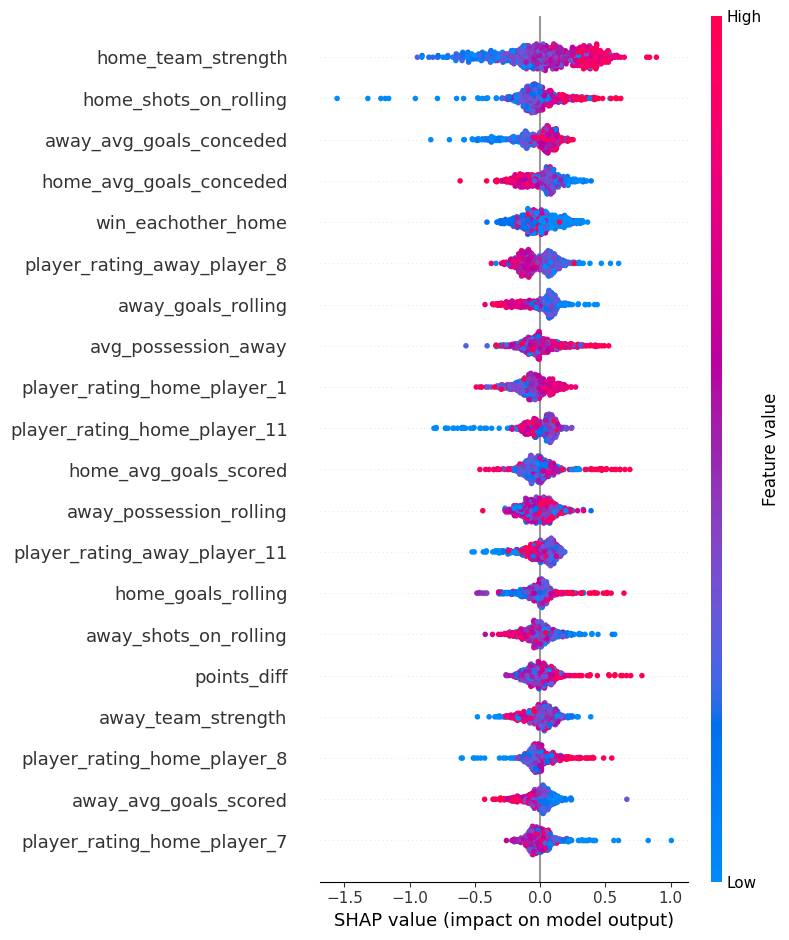

In [72]:
import shap

# Create the SHAP explainer object with the trained model
explainer = shap.Explainer(model)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Summarize the SHAP values for each class
for i in range(shap_values.shape[2]):
    print(f"Class {i} summary plot:")
    shap.summary_plot(shap_values[:, :, i], X_test, feature_names=X_test.columns.tolist())